In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from torchvision import transforms,datasets,models,datasets
import json
from torch import nn
from PIL import Image

In [2]:
# To use gpu if applicable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])
train_dataset = datasets.FashionMNIST('FMNIST', transform=transform)
valid_dataset = datasets.FashionMNIST('FMNIST', train=False, transform=transform)
batch_size = 64
# Create data loaders using train and valid dataset
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
valid_dataset.data.shape

torch.Size([10000, 28, 28])

In [6]:
class_to_labels = {v:k for k,v in train_dataset.class_to_idx.items()}
class_to_labels

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

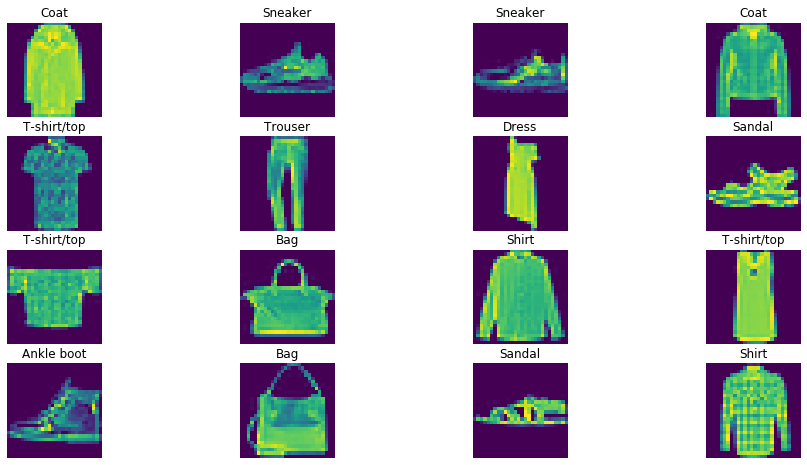

In [7]:
images, labels = next(iter(train_data_loader))
npimgs = images.numpy()[:16] # img is your tensor

# Visualize some images

_, axs = plt.subplots(4, 4, figsize=(16, 8))
axs = axs.flatten()
i = 0
for img,label in zip(npimgs,labels):
    axs[i].imshow(np.squeeze(img))
    axs[i].set_title(class_to_labels[label.item()])
    axs[i].axis('off')
    i+=1
plt.show()

In [44]:
class FMNISTClassifier(nn.Module):
    def __init__(self, debug=False,filter1=32,filter2=64):
        super(FMNISTClassifier, self).__init__()
        self.debug=debug
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=5, padding=2),
            nn.BatchNorm2d(filter1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.2))
        self.seq2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=5, padding=2),
            nn.BatchNorm2d(filter2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.2))
        self.linear = nn.Linear(7*7*filter2, 10)
        self.fc = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.seq1(x)
        if self.debug:
            print(out.shape)
        out = self.seq2(out)
        if self.debug:
            print(out.shape)
        out = out.view(out.size(0), -1)
        if self.debug:
            print(out.shape)
        out = self.linear(out)
        if self.debug:
            print(out.shape)
        return self.fc(out)

In [38]:
images.shape

torch.Size([64, 1, 28, 28])

In [45]:
fmnist_cls = FMNISTClassifier(debug=True)
fmnist_cls(images).shape

torch.Size([64, 32, 14, 14])
torch.Size([64, 64, 7, 7])
torch.Size([64, 3136])
torch.Size([64, 10])


torch.Size([64, 10])

In [46]:
model = FMNISTClassifier()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)
loss_func = nn.NLLLoss()
model.to(device)

FMNISTClassifier(
  (seq1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (seq2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (linear): Linear(in_features=3136, out_features=10, bias=True)
  (fc): LogSoftmax()
)

In [47]:
# Measure the validation loss and accuracy
def validation():
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in iter(valid_data_loader):
            bs = images.size(0)
            images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            outputs = model(images)
            loss += loss_func(outputs, labels).item()*bs
            preds = outputs.argmax(dim=1) # get the index of the max log-probability
            correct += (preds == labels).sum().item()
    
    return loss/len(valid_data_loader.dataset), correct/len(valid_data_loader.dataset)

In [48]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for _ , (inputs, labels) in enumerate(train_data_loader):
        bs = inputs.size(0)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        preds = outputs.argmax(dim=1) # get the index of the max log-probability
        running_corrects += (preds == labels).sum().item()
        # backward + optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * bs
    else:   
        model.eval() # Make sure network is in eval mode for inference
        with torch.no_grad():
            valid_loss, valid_accuracy = validation()
            print("Epoch: {}/{}".format(epoch+1, num_epochs),
                "Training Loss: {:.3f}".format(running_loss/len(train_data_loader.dataset)),
                "Training Accuracy: %{:.2f}".format(100*running_corrects/len(train_data_loader.dataset)),
                "Validation Loss: {:.3f}".format(valid_loss),
                "Validation Accuracy: %{:.2f}".format(100*valid_accuracy))

Epoch: 1/10 Training Loss: 0.438 Training Accuracy: %84.29 Validation Loss: 0.349 Validation Accuracy: %87.11
Epoch: 2/10 Training Loss: 0.314 Training Accuracy: %88.70 Validation Loss: 0.302 Validation Accuracy: %89.33
Epoch: 3/10 Training Loss: 0.284 Training Accuracy: %89.81 Validation Loss: 0.306 Validation Accuracy: %89.21
Epoch: 4/10 Training Loss: 0.267 Training Accuracy: %90.34 Validation Loss: 0.303 Validation Accuracy: %89.05
Epoch: 5/10 Training Loss: 0.260 Training Accuracy: %90.64 Validation Loss: 0.290 Validation Accuracy: %89.76
Epoch: 6/10 Training Loss: 0.252 Training Accuracy: %90.97 Validation Loss: 0.261 Validation Accuracy: %90.64
Epoch: 7/10 Training Loss: 0.246 Training Accuracy: %91.15 Validation Loss: 0.260 Validation Accuracy: %90.45
Epoch: 8/10 Training Loss: 0.243 Training Accuracy: %91.08 Validation Loss: 0.259 Validation Accuracy: %90.57
Epoch: 9/10 Training Loss: 0.238 Training Accuracy: %91.43 Validation Loss: 0.268 Validation Accuracy: %90.28
Epoch: 10/

torch.Size([1, 1, 28, 28])


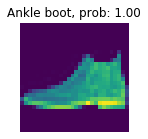

In [67]:
def predict():
    img_org = valid_data_loader.dataset.data[0]
    img = torch.unsqueeze(torch.unsqueeze(valid_data_loader.dataset.data[0],0),0)
    model.eval()
    print(img.shape)
    inputs = img.to(device,dtype=torch.float)
    logits = model(inputs)
    # Convert the score to probaiblity from log probability
    prob = np.e**logits.max()
    label = class_to_labels[logits.argmax(1).item()]
    plt.figure(figsize=(4,2))
    plt.title("%s, prob: %.2f"%(label,prob))
    plt.imshow(img_org)
    plt.axis('off')
    plt.show()
predict()